## Preprocessing version 3
### Details
this version 
- uses all data
- has validation split
- uses pretrained embedding

In [1]:
import csv
import sys
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm
import json
import os
import blingfire
from joblib import Parallel, delayed

UNK = "[UNK]"
BOS = "[CLS]"
EOS = "[SEP]"
PAD = "[PAD]"

def tokenize(s, omit=[]):
    s = s.lower()
    for t in omit:
        s = s.replace(t, '')
    ts = [BOS] + blingfire.text_to_words(s).split() + [EOS]
    return ts
def tokenize_add_vocab(sents, vocab, omit=[]):
    sent_toks = []
    for s in tqdm(sents):
        toks = tokenize(s, omit)
        for t in toks:
            vocab[t] = vocab.get(t, 0) + 1
        sent_toks.append(toks)
    return sent_toks
def tokens_to_ids(tokens, vocab):    
    return [vocab.get(t, vocab[UNK]) for t in tokens]

class Processor:
    def __init__(self, threads):
        self.score = []
        self.summary = []
        self.text = []
        self.omit = ["<br />"]
        self.n_worker = threads        
        self.size = 0

    def make_vocab_and_ids(self, cutoff, verbose=True):
        vocab = {UNK:99999, PAD:99999}
        summary_tok = tokenize_add_vocab(self.summary, vocab, self.omit)
        if verbose:
            print("sum tok done")
        text_tok = tokenize_add_vocab(self.text, vocab, self.omit)
        if verbose:
            print("text tok done")
            print("original vocab", len(vocab))
        vocab = sorted(vocab.items(), key=lambda x: -x[1])[:cutoff]
        vocab = {a:i for i,(a,b) in enumerate(vocab)}
        self.vocab = vocab
        
        summary_gen = tqdm(summary_tok)
        text_gen = tqdm(text_tok)
        
        if self.n_worker < 2:
            self.summary_ids = [tokens_to_ids(t, vocab) for t in summary_gen]
            self.text_ids = [tokens_to_ids(t, vocab) for t in text_gen]
        else:
            #with Pool(self.n_worker) as p:
            #    chunksize = 100                
                #self.summary_ids = list(p.imap(tokens_to_ids, summary_gen))
                #self.text_ids = list(p.imap(tokens_to_ids, text_gen))
            self.summary_ids = Parallel(n_jobs=self.n_worker, backend='multiprocessing')(delayed(tokens_to_ids)(tokens, vocab) for tokens in summary_gen)
            self.text_ids = Parallel(n_jobs=self.n_worker, backend='multiprocessing')(delayed(tokens_to_ids)(tokens, vocab) for tokens in text_gen)
            
        if verbose:
            print("vocab and id done")
        
    def __len__(self):
        return self.size
    
    def dump(self, name, vocabname):
        seqdata = {"text":self.text_ids, "summary":self.summary_ids, "score":self.score}
        json.dump(seqdata, open(name, 'w'))
        if vocabname is not None:
            json.dump(self.vocab, open(vocabname, 'w'))
    
    @staticmethod
    def readcsv(input_file, quotechar="\""):
        """Reads a comma separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter=",", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines
        
class FoodProcessor(Processor):
     def __init__(self, name, threads):
        super(FoodProcessor, self).__init__(threads)
        lines = self.readcsv(name)

        for d in lines[1:]:
            #self.score.append(int(d[6]) > 3) # convert to 0/1
            self.score.append(int(d[6])-1)
            self.summary.append(d[9].strip("\""))
            self.text.append(d[9].strip("\""))
        self.size = len(self.text)   
            
class IMDBProcessor(Processor):
    def __init__(self, dirname, threads):
        super(IMDBProcessor, self).__init__(threads)
        
        posdir = os.path.join(dirname, 'pos')
        negdir = os.path.join(dirname, 'neg')
        
        self.score = []
        self.text = []
        self.summary = []
        self.omit = ["<br />"]
        
        for lb,subdir in enumerate(['neg','pos']):
            subdir = os.path.join(dirname, subdir)
            for entry in os.listdir(subdir):
                fname = os.path.join(subdir, entry)
                with open(fname, 'r') as f:
                    t = f.read().strip()
                self.score.append(lb)
                self.text.append(t)
                self.summary.append(t)
        
        self.size = len(self.text)
            
class BBCProcessor(Processor):
     def __init__(self, name, threads):
        super().__init__(threads)
        lines = self.readcsv(name)
        labeldict = {}
        for lb, txt in lines[1:]:
            labeldict[lb] = labeldict.get(lb, len(labeldict))
            self.score.append(labeldict[lb]) # convert to 0/1
            self.summary.append(txt)
            self.text.append(txt)
        self.size = len(self.text)   
        
class EmotionProcessor(Processor):
     def __init__(self, name, threads):
        super().__init__(threads)
        lines = self.readcsv(name)
        emo = {}
        for d in lines[1:]:
            self.summary.append(d[1])
            self.text.append(d[1])
            emo[d[2]] = emo.get(d[2], len(emo))
            self.score.append(emo[d[2]])
        print(emo)
        self.size = len(self.text)   

In [2]:
# take a break

In [3]:
p = EmotionProcessor("data/emotion.csv", 1)

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}


In [4]:
p.make_vocab_and_ids(cutoff=30000)


sum tok done



text tok done
original vocab 75305


vocab and id done


In [5]:
!mkdir -p data/Emotion/
p.dump("data/Emotion/data.json", "data/Emotion/vocab.json")

In [6]:
index = 999
vocab_inv = {a:b for b,a in p.vocab.items()}

print([vocab_inv[i] for i in p.text_ids[index]])

['[CLS]', 'i', 'am', 'feeling', 'broke', 'emotionally', 'physically', 'and', 'mentally', '[SEP]']


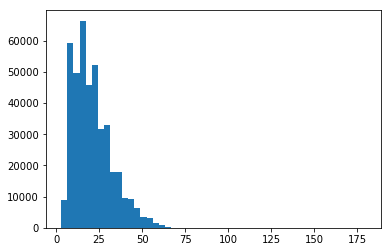

In [10]:
lens = [len(x) for x in p.text_ids]
import matplotlib.pyplot as plt
plt.hist(lens, bins=50)
plt.show()

In [11]:
import numpy as np
print(np.mean(lens), np.std(lens))

21.21547759285428 11.053684938007098


In [9]:
plt.show()